#### This notebook demonstrates the use of adversarial debiasing algorithm to learn a fair classifier.
Adversarial debiasing [1] is an in-processing technique that learns a classifier to maximize prediction accuracy and simultaneously reduce an adversary's ability to determine the protected attribute from the predictions. This approach leads to a fair classifier as the predictions cannot carry any group discrimination information that the adversary can exploit. We will see how to use this algorithm for learning models with and without fairness constraints and apply them on the Adult dataset.

In [2]:
%load_ext autoreload
%autoreload 2


from aif360.algorithms.inprocessing.xgb_adversarial_debiasing import (
    XGBAdversarialDebiasing,
)
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import (
    load_preproc_data_german,
)
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from IPython.display import Markdown, display

2025-01-02 23:38:21.404008: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735861101.418067 4014921 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735861101.422306 4014921 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-02 23:38:21.437976: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


#### Load dataset and set options

In [3]:
dataset_orig = load_preproc_data_german(["age", "sex"])
privileged_groups = [{"age": 1}]
unprivileged_groups = [{"age": 0}]

dataset_orig_train, dataset_orig_test = dataset_orig.split(
    [0.7], shuffle=True, seed=1234
)

/home/ubuntu/AIF360_dev/aif360/algorithms/preprocessing/optim_preproc_helpers/data_preproc_functions.py:261: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sex'] = df['personal_status'].replace(status_map)


In [4]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(
    dataset_orig_train.privileged_protected_attributes,
    dataset_orig_train.unprivileged_protected_attributes,
)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(700, 11)


#### Favorable and unfavorable labels

1.0 2.0


#### Protected attribute names

['age', 'sex']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['age', 'sex', 'credit_history=Delay', 'credit_history=None/Paid', 'credit_history=Other', 'savings=500+', 'savings=<500', 'savings=Unknown/None', 'employment=1-4 years', 'employment=4+ years', 'employment=Unemployed']


#### Metric for original training data

In [5]:
# Metric for the original dataset
metric_orig = BinaryLabelDatasetMetric(
    dataset_orig,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)

display(Markdown("#### Original dataset"))
print(
    "Overall: Difference in mean outcomes between unprivileged and privileged groups = %f"
    % metric_orig.mean_difference()
)
# Metric for the training dataset

metric_orig_train = BinaryLabelDatasetMetric(
    dataset_orig_train,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)
display(Markdown("#### Original training dataset"))
print(
    "Train set: Difference in mean outcomes between unprivileged and privileged groups = %f"
    % metric_orig_train.mean_difference()
)
# Metric for the Test dataset

metric_orig_test = BinaryLabelDatasetMetric(
    dataset_orig_test,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)
print(
    "Test set: Difference in mean outcomes between unprivileged and privileged groups = %f"
    % metric_orig_test.mean_difference()
)

#### Original dataset

Overall: Difference in mean outcomes between unprivileged and privileged groups = -0.149448


#### Original training dataset

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.135639
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.183895


### Learn plan classifier without debiasing

In [6]:
tuning_settings = {
    "time_budget": 60,  # total running time in seconds
}   

In [9]:
#from _utils import _XGBAdversarialDebiasing

plain_model = XGBAdversarialDebiasing(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
    tune_hyperparameters=True,
    tuning_settings=tuning_settings,
    seed=1234,
    debias=False,
)

In [ ]:
plain_model.fit(dataset_orig_train)

[flaml.automl.logger: 01-02 23:38:35] {1728} INFO - task = classification
[flaml.automl.logger: 01-02 23:38:35] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 01-02 23:38:35] {1838} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 01-02 23:38:35] {1955} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 01-02 23:38:35] {2258} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 01-02 23:38:35] {2393} INFO - Estimated sufficient time budget=533s. Estimated necessary time budget=1s.
[flaml.automl.logger: 01-02 23:38:35] {2442} INFO -  at 0.1s,	estimator xgboost's best error=0.3692,	best estimator xgboost's best error=0.3692
[flaml.automl.logger: 01-02 23:38:35] {2258} INFO - iteration 1, current learner xgboost


[flaml.automl.logger: 01-02 23:38:35] {2442} INFO -  at 0.1s,	estimator xgboost's best error=0.3667,	best estimator xgboost's best error=0.3667
[flaml.automl.logger: 01-02 23:38:35] {2258} INFO - iteration 2, current learner xgboost
[flaml.automl.logger: 01-02 23:38:35] {2442} INFO -  at 0.2s,	estimator xgboost's best error=0.3667,	best estimator xgboost's best error=0.3667
[flaml.automl.logger: 01-02 23:38:35] {2258} INFO - iteration 3, current learner xgboost
[flaml.automl.logger: 01-02 23:38:35] {2442} INFO -  at 0.3s,	estimator xgboost's best error=0.3667,	best estimator xgboost's best error=0.3667
[flaml.automl.logger: 01-02 23:38:35] {2258} INFO - iteration 4, current learner xgboost
[flaml.automl.logger: 01-02 23:38:35] {2442} INFO -  at 0.3s,	estimator xgboost's best error=0.3660,	best estimator xgboost's best error=0.3660
[flaml.automl.logger: 01-02 23:38:35] {2258} INFO - iteration 5, current learner xgboost
[flaml.automl.logger: 01-02 23:38:35] {2442} INFO -  at 0.4s,	estima

In [7]:
# Apply the plain model to test data
dataset_nodebiasing_train = plain_model.predict(dataset_orig_train)
dataset_nodebiasing_test = plain_model.predict(dataset_orig_test)

In [8]:
# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
metric_dataset_nodebiasing_train = BinaryLabelDatasetMetric(
    dataset_nodebiasing_train,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)

print(
    "Train set: Difference in mean outcomes between unprivileged and privileged groups = %f"
    % metric_dataset_nodebiasing_train.mean_difference()
)

metric_dataset_nodebiasing_test = BinaryLabelDatasetMetric(
    dataset_nodebiasing_test,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)

print(
    "Test set: Difference in mean outcomes between unprivileged and privileged groups = %f"
    % metric_dataset_nodebiasing_test.mean_difference()
)

display(Markdown("#### Plain model - without debiasing - classification metrics"))
classified_metric_nodebiasing_test = ClassificationMetric(
    dataset_orig_test,
    dataset_nodebiasing_test,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)
print(
    "Test set: Classification accuracy = %f"
    % classified_metric_nodebiasing_test.accuracy()
)
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5 * (TPR + TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print(
    "Test set: Disparate impact = %f"
    % classified_metric_nodebiasing_test.disparate_impact()
)
print(
    "Test set: Equal opportunity difference = %f"
    % classified_metric_nodebiasing_test.equal_opportunity_difference()
)
print(
    "Test set: Average odds difference = %f"
    % classified_metric_nodebiasing_test.average_odds_difference()
)
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())

#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.317572
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.376706


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.723333
Test set: Balanced classification accuracy = 0.539750
Test set: Disparate impact = 0.616882
Test set: Equal opportunity difference = -0.311712
Test set: Average odds difference = -0.395856
Test set: Theil_index = 0.107617


### Apply in-processing algorithm based on adversarial learning

In [ ]:
#from _utils import XGBAdversarialDebiasing

protected_attribute_name = "age"
Z = dataset_orig_train.protected_attributes[
    :,
    dataset_orig_train.protected_attribute_names.index(protected_attribute_name),
]
debiased_model = XGBAdversarialDebiasing(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
    seed=1234,
    debias=True,
    tune_hyperparameters=True,
    tuning_settings=tuning_settings,
    protected_group_vector=Z,
    adversary_loss_weight=10,
    debug=True,
)

In [10]:
dataset_orig_test.labels.shape

(300, 1)

In [11]:
def get_X_Y(dataset):
    X = dataset.features
    # Map the dataset labels to 0 and 1.
    temp_labels = dataset.labels.copy()

    temp_labels[(dataset.labels == dataset.favorable_label).ravel(), 0] = 1.0
    temp_labels[(dataset.labels == dataset.unfavorable_label).ravel(), 0] = 0.0
    Y = temp_labels
    return X, Y

In [12]:
X, Y = get_X_Y(dataset_orig_train)

In [13]:
debiased_model.estimator

AutoML(append_log=False, auto_augment=True, custom_hp={},
       cv_score_agg_func=None, early_stop=False, ensemble=False,
       estimator_list='auto', eval_method='auto', fit_kwargs_by_estimator={},
       force_cancel=False, free_mem_ratio=0, hpo_method='auto',
       keep_search_state=False, learner_selector='sample', log_file_name='',
       log_training_metric=False, log_type='better', max_iter=None,
       mem_thres=4294967296, metric='auto', metric_constraints=[],
       min_sample_size=10000, mlflow_exp_name=None, mlflow_logging=True,
       model_history=False, n_concurrent_trials=1, n_jobs=-1, n_splits=5,
       pred_time_limit=inf, preserve_checkpoint=True, ...)

In [14]:
debiased_model.fit(dataset=dataset_orig_train, test_dataset=dataset_orig_test)

(700, 11) (700, 1) (300, 11) (300, 1)
[flaml.automl.logger: 12-31 04:02:42] {1728} INFO - task = classification
[flaml.automl.logger: 12-31 04:02:42] {1736} INFO - Data split method: stratified
[flaml.automl.logger: 12-31 04:02:42] {1739} INFO - Evaluation method: holdout
[flaml.automl.logger: 12-31 04:02:42] {1838} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 12-31 04:02:42] {1955} INFO - List of ML learners in AutoML Run: ['AdversaryLossXGB']
[flaml.automl.logger: 12-31 04:02:42] {2258} INFO - iteration 0, current learner AdversaryLossXGB
adversary_loss=tensor(622.6611, grad_fn=<BinaryCrossEntropyBackward0>)
[ 0.13188441  0.13188441 -0.07862598  0.13188441  0.13188441 -0.07862598
  0.13188441 -0.07862598  0.13188441  0.13188441]
[0.01036954 0.01036954 0.01036954 0.01036954 0.01036954 0.01036954
 0.01036954 0.01036954 0.01036954 0.01036954]
adversary_loss=tensor(581.8789, grad_fn=<BinaryCrossEntropyBackward0>)
[ 0.10991629  0.11018618 -0.07485875  0.10991629  0.1101

adversary_loss=tensor(622.6611, grad_fn=<BinaryCrossEntropyBackward0>)
[ 0.13188441  0.13188441 -0.07862598  0.13188441  0.13188441 -0.07862598
  0.13188441 -0.07862598  0.13188441  0.13188441]
[0.01036954 0.01036954 0.01036954 0.01036954 0.01036954 0.01036954
 0.01036954 0.01036954 0.01036954 0.01036954]
adversary_loss=tensor(582.1432, grad_fn=<BinaryCrossEntropyBackward0>)
[ 0.1099523   0.11015303 -0.07498716  0.1099523   0.11015303 -0.07498716
  0.1102438  -0.0742449   0.11015303  0.1099523 ]
[ 5.7167457e-03  3.1961605e-03  1.1707335e-02  5.7167457e-03
  3.1961605e-03  1.1707335e-02 -8.3131788e-05  1.3753333e-02
  3.1961605e-03  5.7167457e-03]
adversary_loss=tensor(544.7324, grad_fn=<BinaryCrossEntropyBackward0>)
[ 0.08945891  0.08936181 -0.06945683  0.08945891  0.08936181 -0.06945683
  0.08945275 -0.06861751  0.08936181  0.08945891]
[-0.0011336  -0.00317797  0.01350113 -0.0011336  -0.00317797  0.01350113
 -0.00135876  0.01529062 -0.00317797 -0.0011336 ]
adversary_loss=tensor(508.78

In [16]:
# Apply the plain model to test data
dataset_debiasing_train = debiased_model.predict(dataset_orig_train)
dataset_debiasing_test = debiased_model.predict(dataset_orig_test)

In [17]:
# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
print(
    "Train set: Difference in mean outcomes between unprivileged and privileged groups = %f"
    % metric_dataset_nodebiasing_train.mean_difference()
)
print(
    "Test set: Difference in mean outcomes between unprivileged and privileged groups = %f"
    % metric_dataset_nodebiasing_test.mean_difference()
)

# Metrics for the dataset from model with debiasing
display(Markdown("#### Model - with debiasing - dataset metrics"))
metric_dataset_debiasing_train = BinaryLabelDatasetMetric(
    dataset_debiasing_train,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)

print(
    "Train set: Difference in mean outcomes between unprivileged and privileged groups = %f"
    % metric_dataset_debiasing_train.mean_difference()
)

metric_dataset_debiasing_test = BinaryLabelDatasetMetric(
    dataset_debiasing_test,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)

print(
    "Test set: Difference in mean outcomes between unprivileged and privileged groups = %f"
    % metric_dataset_debiasing_test.mean_difference()
)


display(Markdown("#### Plain model - without debiasing - classification metrics"))
print(
    "Test set: Classification accuracy = %f"
    % classified_metric_nodebiasing_test.accuracy()
)
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5 * (TPR + TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print(
    "Test set: Disparate impact = %f"
    % classified_metric_nodebiasing_test.disparate_impact()
)
print(
    "Test set: Equal opportunity difference = %f"
    % classified_metric_nodebiasing_test.equal_opportunity_difference()
)
print(
    "Test set: Average odds difference = %f"
    % classified_metric_nodebiasing_test.average_odds_difference()
)
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())


display(Markdown("#### Model - with debiasing - classification metrics"))
classified_metric_debiasing_test = ClassificationMetric(
    dataset_orig_test,
    dataset_debiasing_test,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)
print(
    "Test set: Classification accuracy = %f"
    % classified_metric_debiasing_test.accuracy()
)
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
bal_acc_debiasing_test = 0.5 * (TPR + TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_debiasing_test)
print(
    "Test set: Disparate impact = %f"
    % classified_metric_debiasing_test.disparate_impact()
)
print(
    "Test set: Equal opportunity difference = %f"
    % classified_metric_debiasing_test.equal_opportunity_difference()
)
print(
    "Test set: Average odds difference = %f"
    % classified_metric_debiasing_test.average_odds_difference()
)
print("Test set: Theil_index = %f" % classified_metric_debiasing_test.theil_index())

#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.317572
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.376706


#### Model - with debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.009992
Test set: Difference in mean outcomes between unprivileged and privileged groups = 0.012895


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.723333
Test set: Balanced classification accuracy = 0.539750
Test set: Disparate impact = 0.616882
Test set: Equal opportunity difference = -0.311712
Test set: Average odds difference = -0.395856
Test set: Theil_index = 0.107617


#### Model - with debiasing - classification metrics

Test set: Classification accuracy = 0.736667
Test set: Balanced classification accuracy = 0.516267
Test set: Disparate impact = 1.013284
Test set: Equal opportunity difference = -0.011562
Test set: Average odds difference = 0.031256
Test set: Theil_index = 0.067829


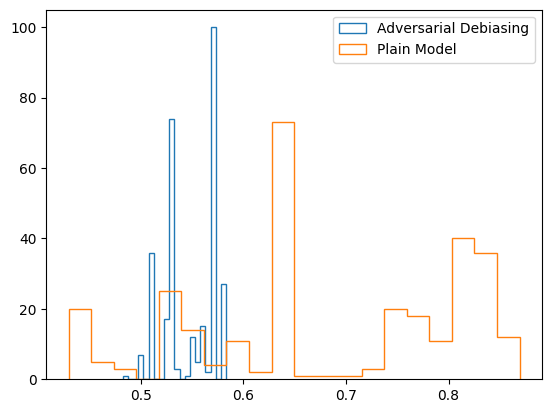

In [18]:
import matplotlib.pyplot as plt

bins = 20
probs_ad = debiased_model.predict_proba(dataset_orig_test)[:, 1]
base_probs = plain_model.predict_proba(dataset_orig_test)[:, 1]
# plt.hist(adjusted_probs, bins=bins, histtype="step", label="Fairness Adjuster")
plt.hist(probs_ad, bins=bins, histtype="step", label="Adversarial Debiasing")
plt.hist(base_probs, bins=bins, histtype="step", label="Plain Model")
plt.legend()
plt.show()


    References:
    [1] B. H. Zhang, B. Lemoine, and M. Mitchell, "Mitigating UnwantedBiases with Adversarial Learning," 
    AAAI/ACM Conference on Artificial Intelligence, Ethics, and Society, 2018.